# Run an agent based SEIRX simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../nursing_home')
from model_school import SEIRX_school
import viz

## Single model run

In [3]:
school_name = 'test_volksschule'
# interaction network of inhabitants
G = nx.readwrite.gpickle.read_gpickle('../data/school/{}.gpickle'.format(school_name))
# number of steps (days) the simulation will run
N_steps = 50
# verbosity level (can be 0, 1, 2) that prints increasingly detailed information
# about the simulation
verbosity = 0
# enables testing and tracing actions (run with testing=False) to simulate
# unhindered spread of the virus through the nursing home
testing = 'preventive'
# introduce a single index case through a teacher
index_case = 'teacher'
# test technology and turnover time used in the simulation
preventive_screening_test_type = 'one_day_PCR'
# agent types used in the simulation with their respective parameters
agent_types = {
        'student':{
            'screening_interval': None,
            'index_probability': 0,
            'transmission_risk': 0.1,
            'reception_risk': 1,
            'mask':False},
    
        'teacher':{
            'screening_interval': 7,
            'index_probability': 0,
            'transmission_risk': 0.1,
            'reception_risk': 1,
            'mask':True},
    
        'family_member':{
            'screening_interval': None,
            'index_probability': 0,
            'transmission_risk': 0.1,
            'reception_risk': 1,
            'mask':False}
}

# fixed seed of the simulation, using the same seed repeats the same simulation
# if the same parameters are chosen. Setting seed = None corresponds to a random
# initialization.
seed = 3

model = SEIRX_school(
    G,verbosity=verbosity, testing=testing,
    index_case=index_case, agent_types = agent_types,
    preventive_screening_test_type=preventive_screening_test_type)

for i in range(N_steps):
    if verbosity > 0: print('*** step {} ***'.format(i+1))
    model.step()

### Visualise time-series of student infections

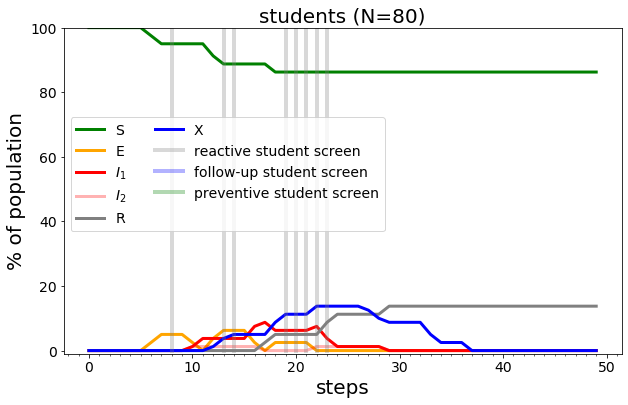

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
viz.draw_infection_timeline(model, 'student', ax)

### Visualise time-series of teacher infections

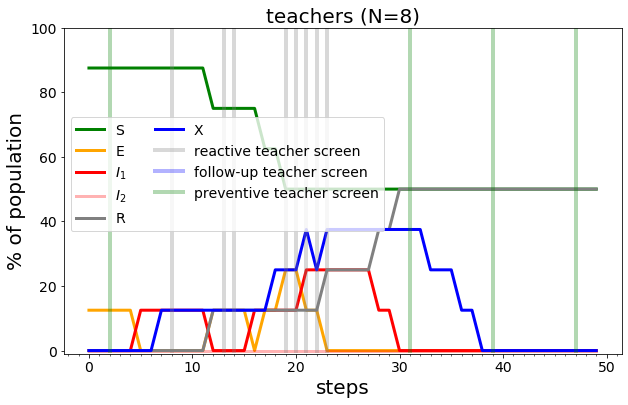

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
viz.draw_infection_timeline(model, 'teacher', ax)

### Have a peek at the raw data

In [6]:
data = model.datacollector.get_model_vars_dataframe()
data.head(5)

,E_student,I_student,I_asymptomatic_student,I_symptomatic_student,R_student,X_student,E_teacher,I_teacher,I_asymptomatic_teacher,I_symptomatic_teacher,...,screen_teachers_follow_up,screen_teachers_preventive,screen_family_members_reactive,screen_family_members_follow_up,screen_family_members_preventive,N_diagnostic_tests,N_preventive_screening_tests,undetected_infections,predetected_infections,pending_test_infections
0,0,0,0,0.0,0,0,1,0,0,0.0,...,False,False,False,False,False,0,0,0,0,0
1,0,0,0,0.0,0,0,1,0,0,0.0,...,False,False,False,False,False,0,0,0,0,0
2,0,0,0,0.0,0,0,1,0,0,0.0,...,False,True,False,False,False,8,0,0,0,0
3,0,0,0,0.0,0,0,1,0,0,0.0,...,False,False,False,False,False,8,0,0,0,0
4,0,0,0,0.0,0,0,1,0,0,0.0,...,False,False,False,False,False,8,0,0,0,0
